In [0]:
!pip install tensorflow

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from PIL import Image
lr = 3.0
size = 224
iterations = 3000
style_wt = 1e5
content_wt = 1.0
content_image_path = "content.jpg"
style_image_path = "style.jpg"
print("TensorFlow version:", tf.__version__)
style_layer_wts = [1.0, 0.5, 0.1, 0.1, 0.5]

TensorFlow version: 2.2.0


In [8]:
model = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(size, size, 3))
model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(size, size))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return np.expand_dims(img, axis = 0)

In [12]:
from google.colab import files
uploaded = files.upload()

Saving content.jpg to content.jpg
Saving style.jpg to style.jpg


In [0]:
def deprocess(x):
    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image, axis = 0)

    img = deprocess(img)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

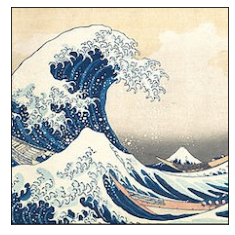

In [13]:
display_image(preprocess_image(style_image_path))

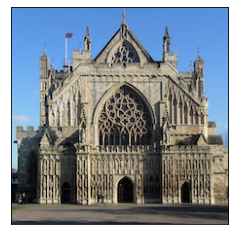

In [14]:
display_image(preprocess_image(content_image_path))

In [0]:
content_layer = 'block4_conv2'
content_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)

In [0]:
style_layers = [ 'block1_conv1', 'block1_conv2','block2_conv1', 'block2_conv2','block3_conv1' ]
style_models = [ tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer).output) for layer in style_layers ]

In [29]:
x = preprocess_image(style_image_path)

temp_layer = 'block1_conv1'
temp_model = tf.keras.models.Model(model.input, model.get_layer(temp_layer).output)

out = temp_model.predict(x)[0] # 0 is to get the activation for the 1st training example bcoz the output is of the form M * nH * nW * nC

print(out)
print(out.shape)

[[[  0.           7.1442585   11.064676   ...   0.          16.370743
     0.        ]
  [  0.          17.95728     55.58947    ...   0.         161.91441
   117.45252   ]
  [  0.          19.809227    60.48693    ...   0.         176.65492
   132.9093    ]
  ...
  [  0.          23.597218    66.352104   ...   0.         189.5315
   142.85927   ]
  [  0.          23.953037    66.60205    ...   0.         188.54614
   141.76488   ]
  [  6.432896    44.640408   114.581314   ...   0.         322.78894
   321.8667    ]]

 [[  0.           5.666713     0.         ...   0.           0.
     0.        ]
  [  0.          17.916256    44.879253   ...   0.           0.
    23.214201  ]
  [  0.          19.98631     49.881126   ...   0.           0.8593292
    37.348072  ]
  ...
  [  0.          25.470795    54.0563     ...   0.           0.
    35.62894   ]
  [  0.          25.644575    52.48528    ...   0.           0.
    27.867744  ]
  [266.40808     55.793842   128.95981    ...   0.        

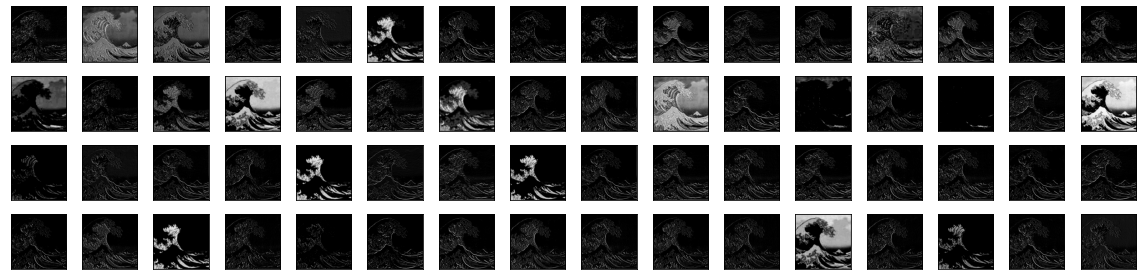

In [40]:
plt.figure(figsize=(16,4))
for i in range(0, 64):
    plt.subplot(4, 16, i + 1)
    plt.imshow(out[:,:,i], cmap='gray') # printing all nW and nH for the Ith channel i.e. the output of each filter
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [0]:
# Content Cost
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

In [0]:
def gram_matrix(M):
    num_channels = tf.shape(M)[-1]
    M = tf.reshape(M, shape=(-1, num_channels))
    n = tf.shape(M)[0]
    G = tf.matmul(tf.transpose(M), M)
    return G / tf.cast(n, dtype=tf.float32)

In [0]:
def style_cost(style_img, generated_img):
    total_cost = 0
    for i, style_model in enumerate(style_models):
        S = style_model(style_img)
        G = style_model(generated_img)
        GS = gram_matrix(S)
        GG = gram_matrix(G)
        current_cost = style_layer_wts[i] * tf.reduce_mean(tf.square(GS - GG))
        total_cost += current_cost
    
    total_cost /= (size * size * len(style_models))
    return total_cost

In [0]:
content_image_preprocessed = preprocess_image(content_image_path)
style_image_preprocessed = preprocess_image(style_image_path)
generated_image = tf.Variable(content_image_preprocessed, dtype=tf.float32)

generated_images = []
costs = []

optimizer = tf.optimizers.Adam(learning_rate=lr)

for i in range(iterations):
    
    with tf.GradientTape() as tape:
        J_content = content_cost(content=content_image_preprocessed, generated=generated_image)
        J_style = style_cost(style_img=style_image_preprocessed, generated_img=generated_image)
        J_total = content_wt * J_content + style_wt * J_style
    
    gradients = tape.gradient(J_total, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
   
    costs.append(J_total.numpy())
    
    if i % 200 == 0:
        display_image(generated_image.numpy())
        generated_images.append(generated_image.numpy())
        print("Iteration:{}/{}, Total Cost:{}, Style Cost: {}, Content Cost: {}".format(i+1, iterations, J_total, J_style, J_content))

In [0]:
plt.plot(range(iterations), costs)
plt.xlabel(\"Iterations\")
plt.ylabel(\"Total Cost\")
plt.show()

In [0]:
image = Image.fromarray(deprocess(generated_images[-1][0]))

In [0]:
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('xyz.png')